# Assignment - 2: Data Representation and Point Cloud Operations

Team Name: Doraemon 

Roll number: 2019101020 2019101105

# Instructions

- Code must be written in Python in Jupyter Notebooks. We highly recommend using anaconda distribution or at the minimum, virtual environments for this assignment.
- Save all your results in ```results/<question_number>/<sub_topic_number>/```
- The **References** section provides you with important resources to solve the assignment.
- Make sure your code is modular since you may need to reuse parts for future assignments.
- Answer the descriptive questions in your own words with context & clarity. Do not copy answers from online resources or lecture notes.
- The **deadline** for this assignment is on 26/09/2021 at 11:55pm. Please note that there will be no extensions.
- Plagiarism is **strictly prohibited**.

# Submission Instructions

1. Make sure your code runs without any errors after reinitializing the kernel and removing all saved variables.
2. After completing your code and saving your results, zip the folder with name as ``Team_<team_name>_MR2021_Assignment_<assignment_number>.zip``

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d
%matplotlib inline

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Introduction to types of Transformations and Homogeneous coordinates

In robotics applications, it is inevitable to keep track of the frames of multiple objects/worlds. These frames can be transformations from one coordinate frame to the other. **Homogeneous coordinates** help in keeping track of various coordinate frames and allow performing composition of various transforms. We will first try to understand between types of transformations and their invariant properties.
1. What is the difference between Affine, Similarity, and Euclidean transform? What are the invariant properities of each type of transform?
2. Watch this [video](https://www.youtube.com/watch?v=PvEl63t-opM) to briefly understand homogeneous coordinates. What are points at infinity? What type of transformation can you apply to transform a point from infinity to a point that is not at infinity? 
3. Using homogeneous coordinates we can represent different types of transformation as point transforms vs. frame transforms. Concatenation of transforms (whether you post multiply transformation matrices or pre-multiply transformation matrices) depends on the problem and how you are viewing it. Try to understand the difference between frame vs. point transformations from this [video](https://youtu.be/Za7Sdegf8m8?t=1834). Let's assume that our camera and world frames are coinciding with each other. We need to estimate the camera to world **frame** transformation matrix after applying the transformations defined below in terms of $T_i$.We apply **frame** transform to move the camera in the world in the following order:
    1. $T_1$ from the camera coordinate frame.
    2. $T_2$ from the world coordinate frame.
    3. $T_3$ from the world coordinate frame.
    4. $T_4$ from the camera coordinate frame.
    5. $T_5$ from the camera coordinate frame.


## Answers

1. An affine transform has six degrees of freedom in 2D, i.e., translation, rotation, isotropic scaling, aspect ratio, and shear. A similarity transform has four degrees of freedom in 2D, i.e., translation, rotation, and isotropic scaling. A Euclidean transform has 3 degrees of freedom in 2D, i.e., translation & rotation. A Euclidean transformation is an action that preserves lengths and angles. A similarity transformation preserves ratios of lengths, ratios of areas, and angles. It is the most general transformation that preserves “shape.” Lines are still parallel, and ratios of lengths of parallel line segments are equal after an affine transformation.

2. Points of the form [x, y, z, 0] in homogeneous coordinates are the points at infinity with direction. A point from infinity can be transformed to the point that is not at infinity using projective transformation having non-zero elements in the last row.

3. Required transformation is $T_3T_2T_1T_4T_5$.

# Visualize the Data

Point clouds are a collection of points that represent a 3D shape or feature. Each point has its own set of X, Y and Z coordinates and in some cases additional attributes. A popular way to obtain this is by photogrammetry, though here we will use LiDAR data.

LiDAR is a remote sensing process which collects measurements used to create 3D models and maps of objects and environments. Using ultraviolet, visible, or near-infrared light, LiDAR gauges spatial relationships and shapes by measuring the time it takes for signals to bounce off objects and return to the scanner.

1. Download the data from [here](https://iiitaphyd-my.sharepoint.com/:f:/g/personal/venkata_surya_students_iiit_ac_in/EnYAMaTVIhJItzKYqtahE30BRKB6p6UfHN3TyJzvo6Mw0g?e=PegWds). It contains the LIDAR sensor output and odometry information per frame.

    The .bin files contain the 3D point cloud captured by the LIDAR in this format—x, y, z, and reflectance. 

    The odometry information is given in the `odometry.txt` file, which is a 12 element vector. Reshape each of the first 77 rows to a 3x4 matrix to obtain the pose.
    

2. Obtain the point cloud from this and visualize for 1-2 frames.

## Code

In [2]:
fhand = open("data/odometry.txt")
count = 0
poses = []
for line in fhand:
    count += 1
    pose = np.array(line.split(), dtype=np.float32)
    pose = pose.reshape((3, 4))
    pose = np.vstack((pose, [0, 0, 0, 1]))
    poses.append(pose)
    if count == 77:
        break
poses = np.array(poses)
print(poses.shape)


(77, 4, 4)


In [3]:
def point_cloud_visualize(filename):
    bin_pcd = np.fromfile(filename, dtype=np.float32)
    points = bin_pcd.reshape((-1, 4))[:, 0:3]
    o3d_pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(points))
    o3d.visualization.draw_geometries([o3d_pcd])


point_cloud_visualize("data/LiDAR/000010.bin")
point_cloud_visualize("data/LiDAR/000040.bin")


# Transform 

The point cloud obtained is with respect to the LiDAR frame. The poses however, are in the camera frame. If we want to combine the point clouds from various frames, we need to bring them to the camera frame. 

1. Refer to the image below and apply the required transformation to the point cloud. 

2. Then, register all point clouds into a common reference frame and visualise it (Open3D). It is helpful to use homogeneous coordinates to keep track of the different frames.

3. Write a function to transform the registered point cloud from the world to the $i^{th}$ camera frame, wherein $i$ is the input to the function.

4. \[Bonus\] Move around in the registered point cloud using arrow keys like you would do in a game. For this you will have to regularly transform the entire registered world to your current camera frame and visualize repeatedly. You may choose to avoid visualizing points that are behind the camera in this case as they are not visible from the scene. You may also visualize points at a max depth to make the process easier.

![](./img/transform.png)

## LiDAR to Camera

In [4]:
def rotation_matrix(alpha, beta, gamma):
    Rx = np.array(
        [
            [1.0, 0.0, 0.0, 0.0],
            [0.0, np.cos(alpha), -np.sin(alpha), 0.0],
            [0.0, np.sin(alpha), np.cos(alpha), 0.0],
            [0.0, 0.0, 0.0, 1.0],
        ]
    )
    Ry = np.array(
        [
            [np.cos(beta), 0.0, np.sin(beta), 0.0],
            [0.0, 1.0, 0.0, 0.0],
            [-np.sin(beta), 0.0, np.cos(beta), 0.0],
            [0.0, 0.0, 0.0, 1.0],
        ]
    )
    Rz = np.array(
        [
            [np.cos(gamma), -np.sin(gamma), 0.0, 0.0],
            [np.sin(gamma), np.cos(gamma), 0.0, 0.0],
            [0.0, 0.0, 1.0, 0.0],
            [0.0, 0.0, 0.0, 1.0],
        ]
    )
    rotation_mat = np.matmul(Rz, np.matmul(Ry, Rx))
    return rotation_mat


In [5]:
def get_point_cloud(filename):
    bin_pcd = np.fromfile(filename, dtype=np.float32)
    points = bin_pcd.reshape((-1, 4))[:, 0:3]
    points = np.hstack((points, np.ones((points.shape[0], 1), dtype=points.dtype)))
    return points


In [6]:
get_point_cloud("data/LiDAR/000010.bin").shape

(122829, 4)

In [7]:
lidar_to_camera = rotation_matrix(0, -np.pi / 2, np.pi / 2)

In [8]:
camera_frame = []
for file in range(10, 87):
    filename = f"data/LiDAR/0000{file}.bin"
    points = get_point_cloud(filename)
    camera_frame.append(np.matmul(points, lidar_to_camera.T))


## Camera to World

In [9]:
world_frame = []
for point_cloud in range(len(camera_frame)):
    points = camera_frame[point_cloud]
    world_frame.append(np.matmul(points, poses[point_cloud].T))


## Visualization

In [10]:
world_frame = np.vstack(world_frame)
world_frame = np.true_divide(world_frame[:, 0:3], world_frame[:, [-1]])


In [11]:
world_frame

array([[ -5.75702906,  -1.98781167,  52.3221335 ],
       [-12.75392532,  -2.90621851,  78.84609808],
       [-13.00152588,  -2.90511869,  78.78907599],
       ...,
       [ 83.48220676,   1.34564962,  12.02421429],
       [ 83.47860498,   1.33891395,  12.039236  ],
       [ 83.53348296,   1.36919691,  12.01932357]])

In [12]:
def visualize(point_cloud):
    pcd = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(point_cloud))
    mesh_frame = o3d.geometry.TriangleMesh.create_coordinate_frame(
        size=25, origin=[0, 0, 0]
    )
    o3d.visualization.draw_geometries([mesh_frame, pcd])


In [13]:
visualize(world_frame)

## World to $i^{th}$ Camera Frame

In [14]:
def world_to_camera(camera, points):
    points = np.hstack((points, np.ones((points.shape[0], 1), dtype=points.dtype)))
    points = np.matmul(points, np.linalg.inv(poses[camera]).T)
    return np.true_divide(points[:, 0:3], points[:, [-1]])


In [15]:
visualize(world_to_camera(40, world_frame))


## Animation

In [16]:
def animation():
    source_raw = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(world_to_camera(0, world_frame)))

    source = source_raw.voxel_down_sample(voxel_size=0.002)

    visualizer = o3d.visualization.Visualizer()
    visualizer.create_window()
    visualizer.add_geometry(source)
    
    num_iteration = 77

    for i in range(1, num_iteration):
        visualizer.remove_geometry(source)
        source = o3d.geometry.PointCloud(o3d.utility.Vector3dVector(world_to_camera(i, world_frame)))
        visualizer.add_geometry(source)
        visualizer.poll_events()
        visualizer.update_renderer()
        
    visualizer.destroy_window()

In [17]:
animation()

# Occupancy Map

Occupancy grid maps are discrete fine grain grid maps. These maps can be either 2-D or 3-D. Each cell in the occupancy grid map contains information on the physical objects present in the corresponding space. Since these maps shed light on what parts of the environment are occupied, and what is not, they are really useful for path planning and navigation.

Occupancy grid maps are probabilistic in nature due to noisy measurements. Each cell can have three states: Occupied, unoccupied, and unknown. For the purpose of this assignment, you can ignore the unknown and work in a binary setting where 1 is occupied and 0 is unoccupied.

1. The task here is to create an occupancy map for each LiDAR scan. You do not need to apply bayesian update rules here, just keep it simple. 

2. Now, using the *registered* point cloud, generate occupancy maps for each frame. What difference do you expect to see between the two methods?

You can mark a cell as occupied based on a threshold of how many different z values are there for a particular (x,y) cell.

## Occupancy Grid

In [33]:
def occupancy_grid(point_cloud):
    # -----------------------------------
    # -----Define default parameters-----
    # -----------------------------------

    deviation = 0.0785
    buffer = 3
    cell_resolution = 0.5

    # ------------------------------------------
    # -----Calculate size of Occupancy Grid-----
    # ------------------------------------------

    x_max = float("-inf")
    x_min = float("inf")
    z_max = float("-inf")
    z_min = float("inf")

    for point in point_cloud:
        x_max = max(x_max, point[0])
        x_min = min(x_min, point[0])
        z_max = max(z_max, point[2])
        z_min = min(z_min, point[2])

    # ---------------------------------------
    # -----Populate map with cost values-----
    # ---------------------------------------

    count = [
        [0 for _ in range(int((z_max - z_min) / cell_resolution + 1))]
        for _ in range(int((x_max - x_min) / cell_resolution + 1))
    ]
    grid = [
        [0 for _ in range(int((z_max - z_min) / cell_resolution + 1))]
        for _ in range(int((x_max - x_min) / cell_resolution + 1))
    ]

    for point in point_cloud:
        x = point[0]
        z = point[2]
        
        x_cell = int((x - x_min) / cell_resolution)
        z_cell = int((z - z_min) / cell_resolution)
        count[x_cell][z_cell] += 1

    # ---------------------------------
    # -----Generate Occupancy Grid-----
    # ---------------------------------

    for i in range(len(count)):
        for j in range(len(count[0])):
            if count[i][j] < buffer:
                grid[i][j] = 0
            else:
                grid[i][j] = 1
    return grid


In [29]:
def plot_grid(grid):
    plt.imshow(grid)
    plt.show()

## Occupancy Map for Each Frame Using the LiDAR Scan of that Frame

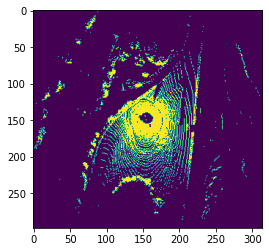

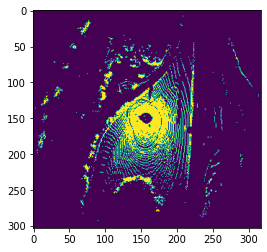

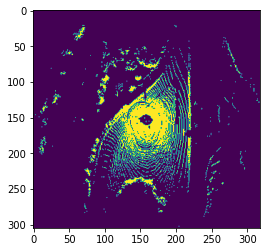

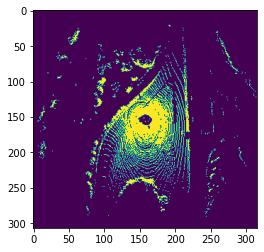

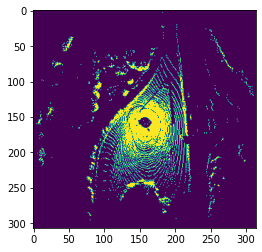

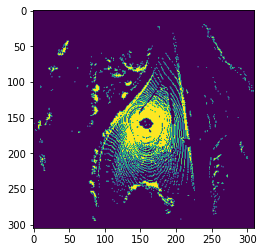

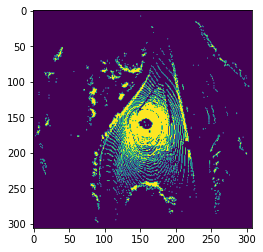

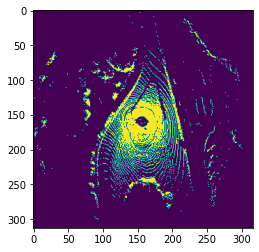

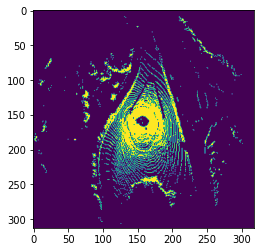

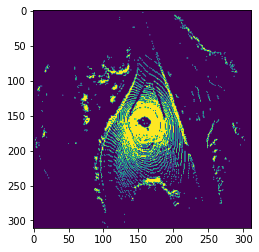

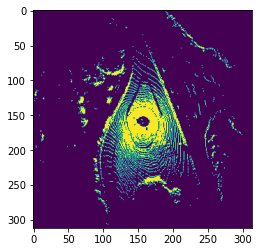

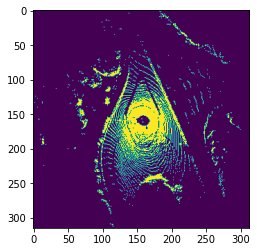

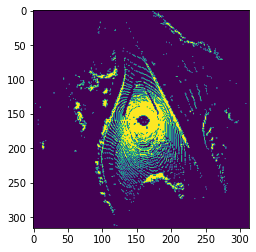

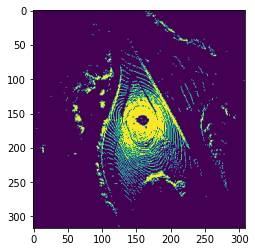

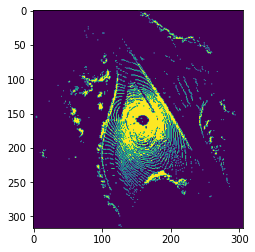

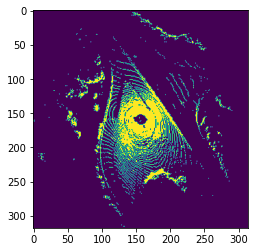

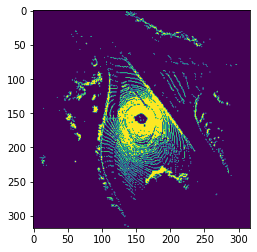

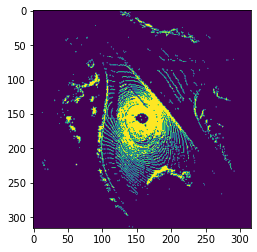

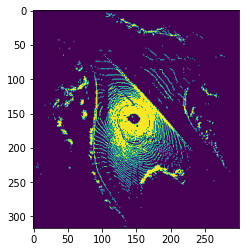

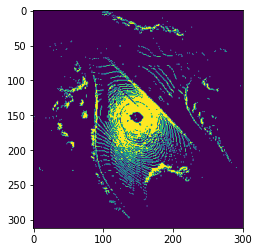

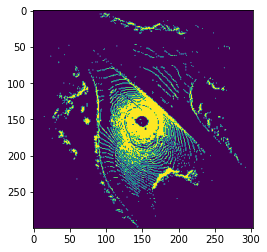

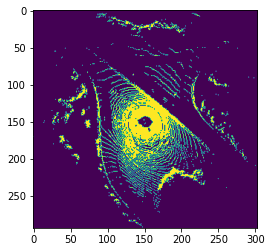

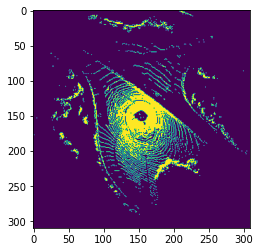

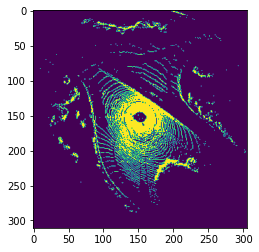

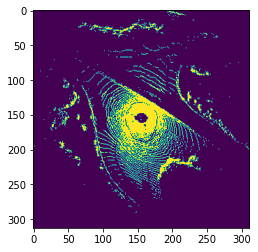

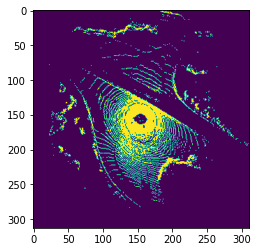

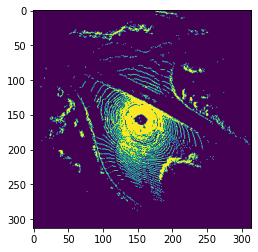

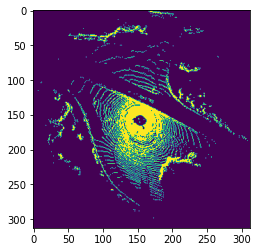

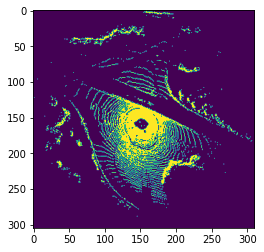

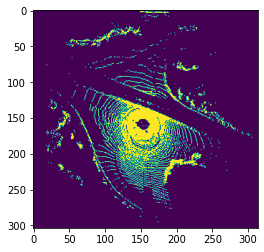

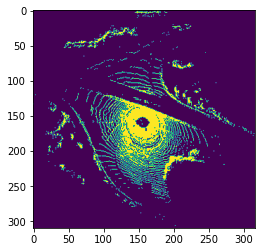

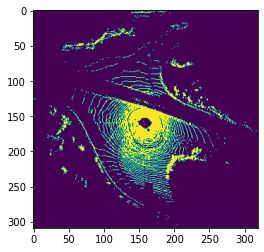

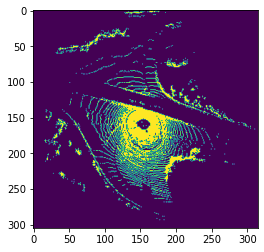

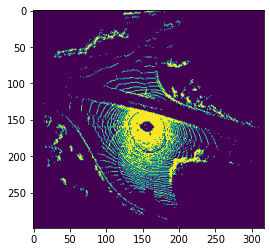

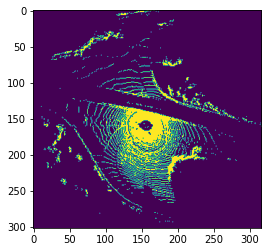

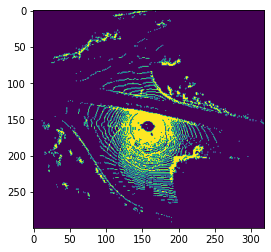

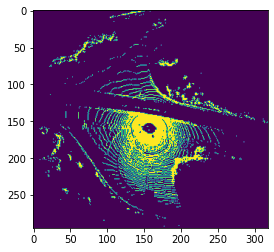

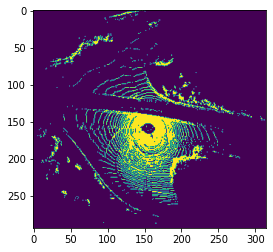

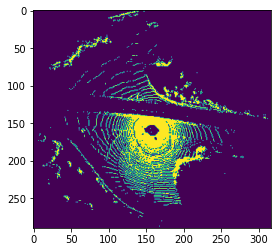

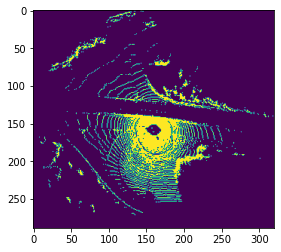

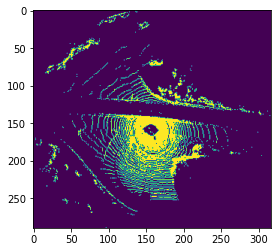

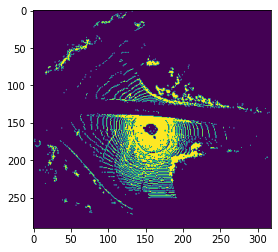

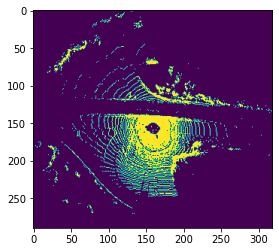

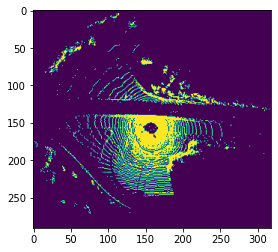

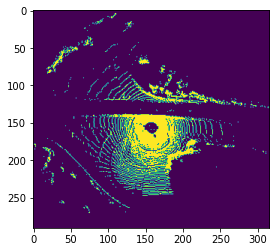

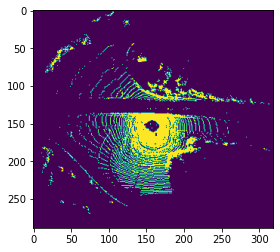

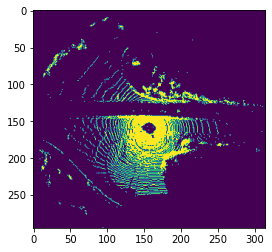

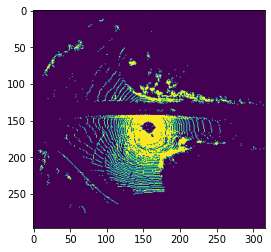

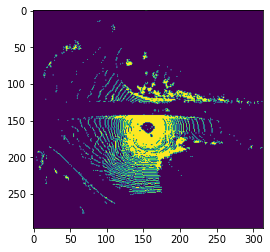

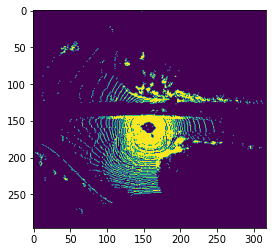

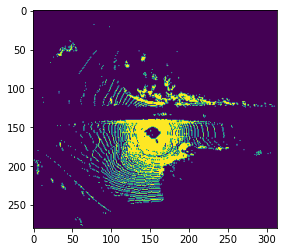

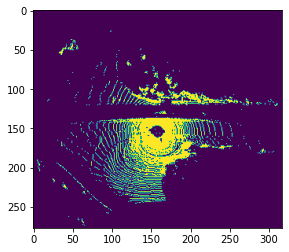

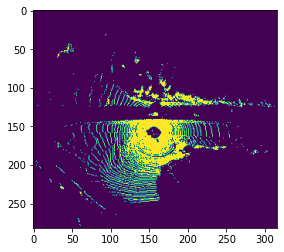

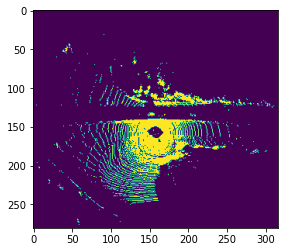

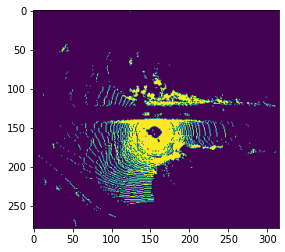

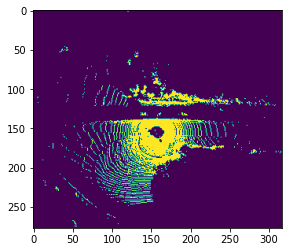

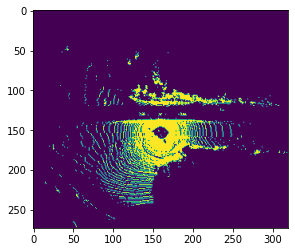

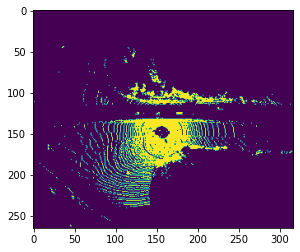

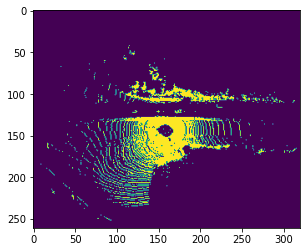

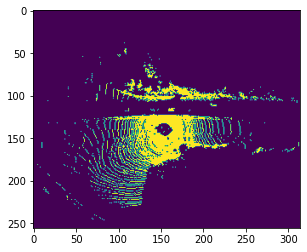

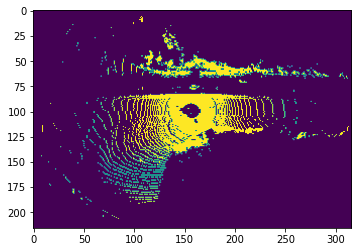

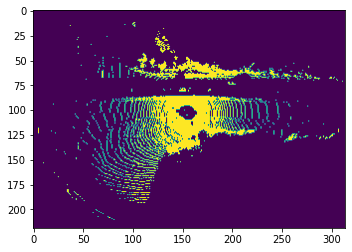

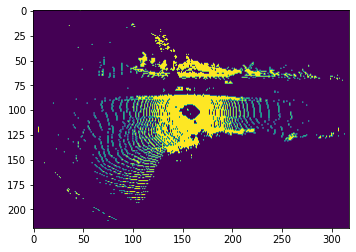

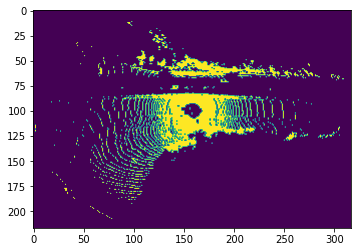

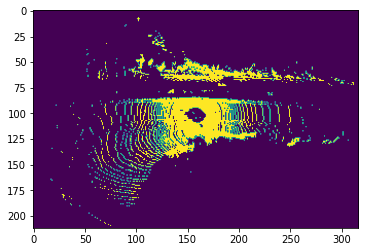

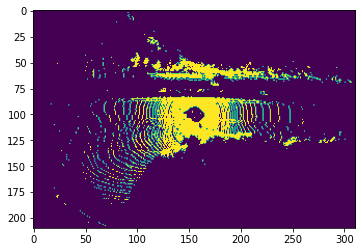

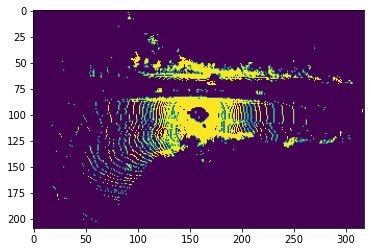

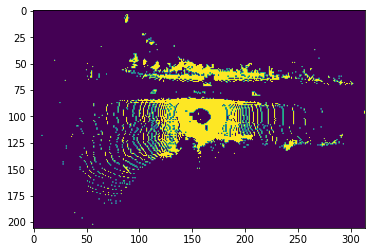

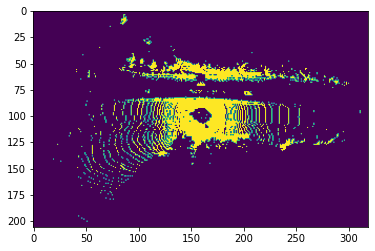

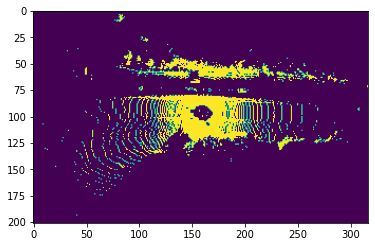

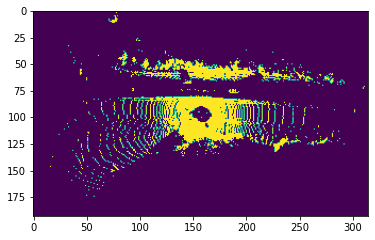

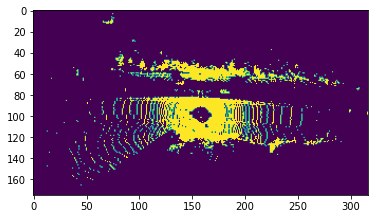

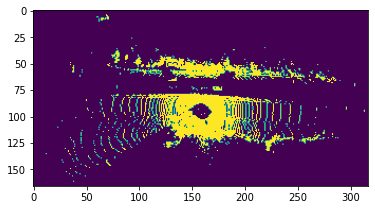

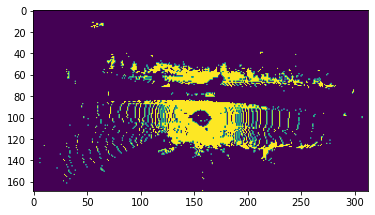

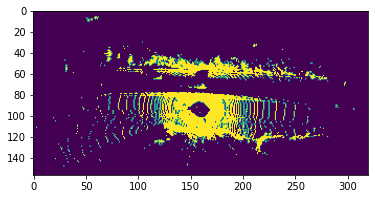

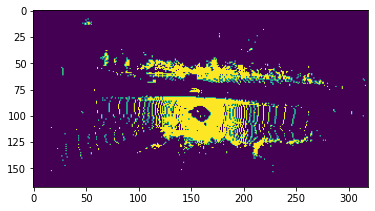

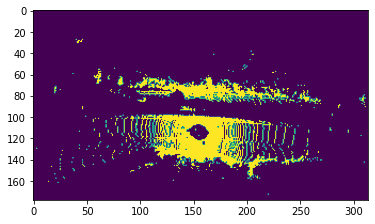

In [34]:
for frame in range(len(camera_frame)):
    plot_grid(occupancy_grid(camera_frame[frame]))

## Occupancy Map for Each Frame Using the Registered Point Cloud

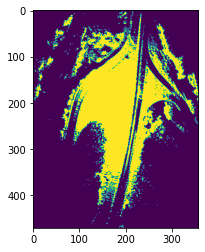

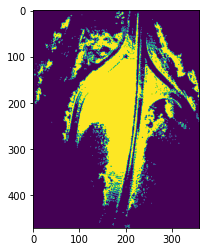

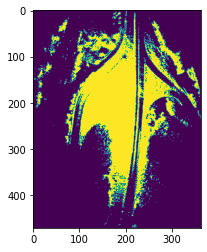

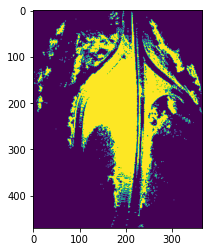

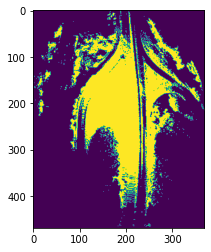

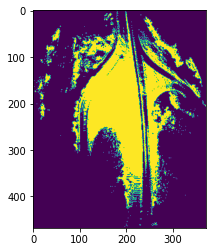

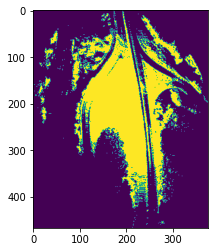

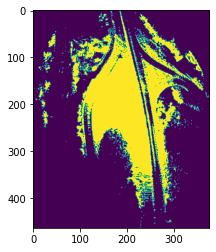

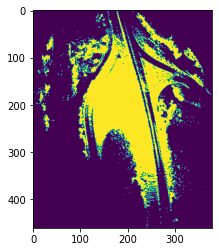

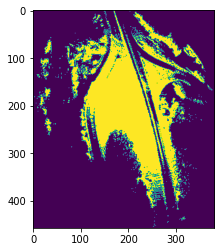

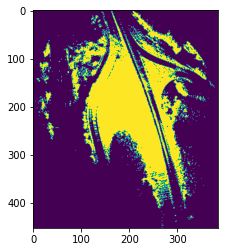

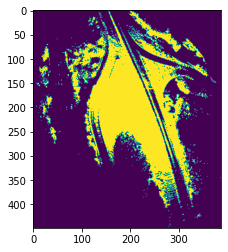

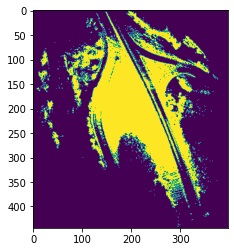

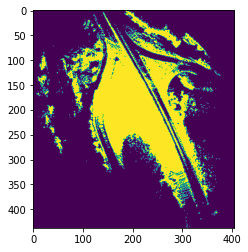

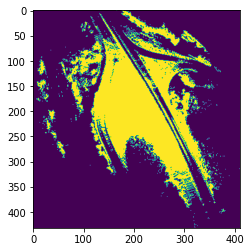

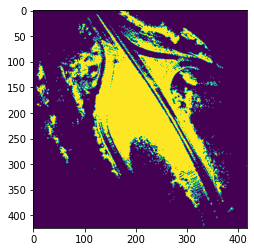

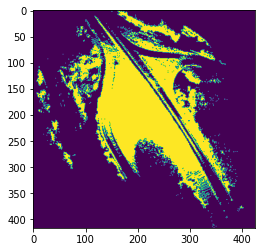

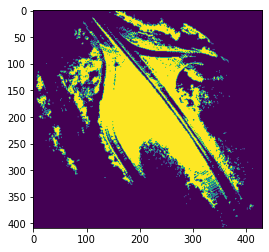

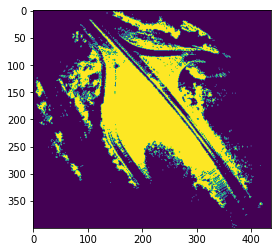

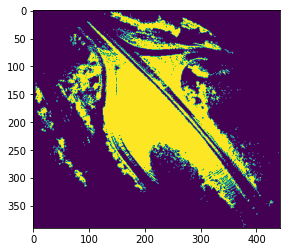

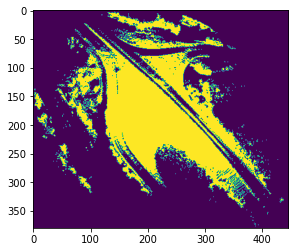

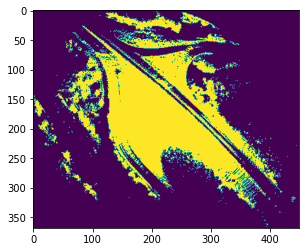

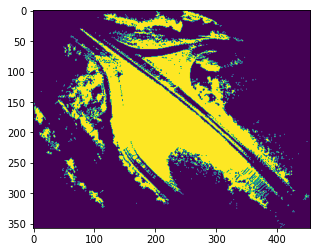

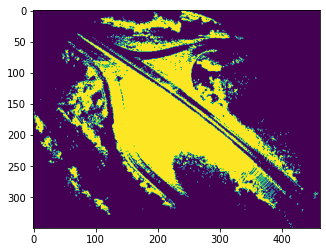

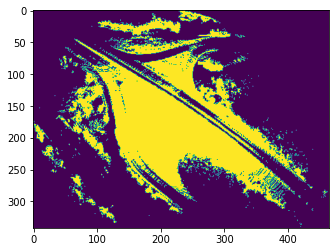

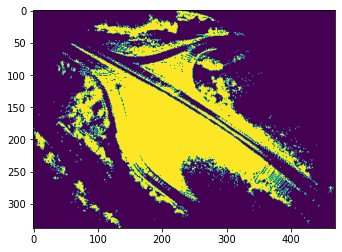

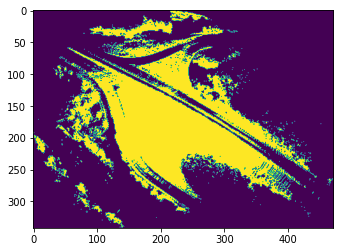

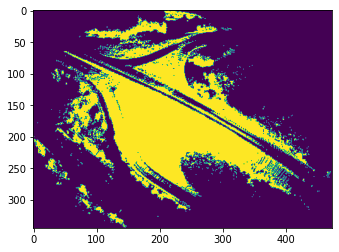

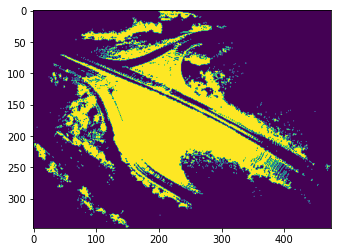

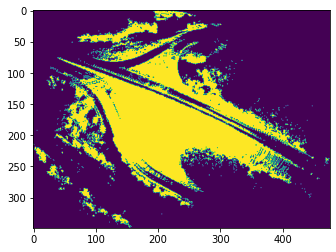

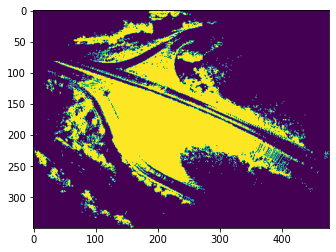

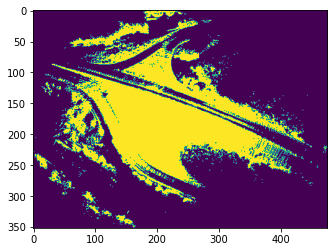

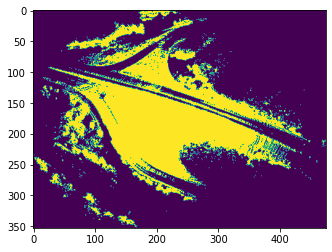

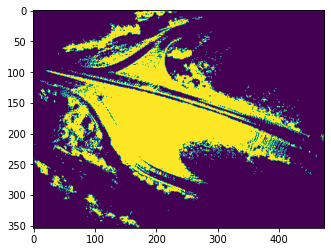

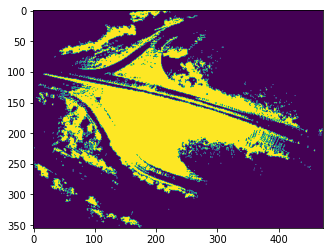

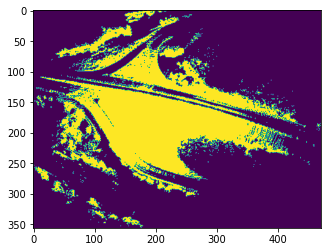

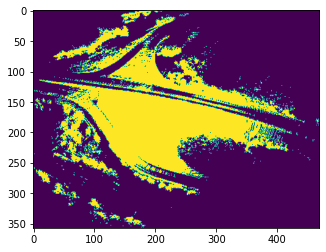

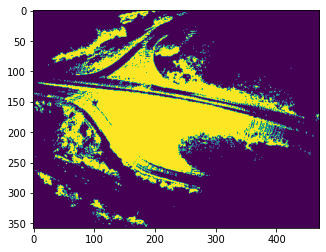

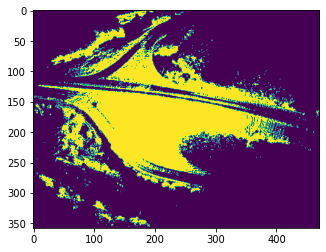

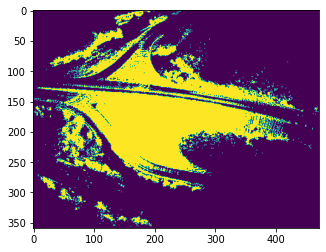

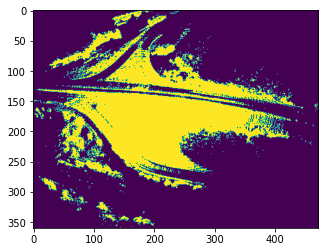

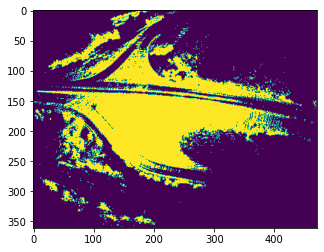

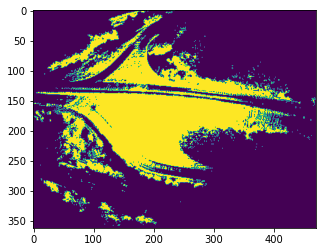

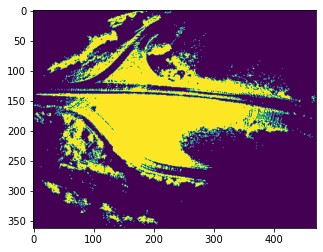

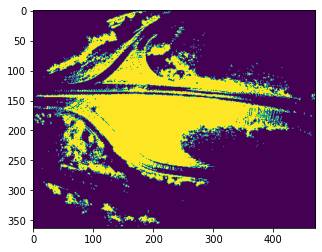

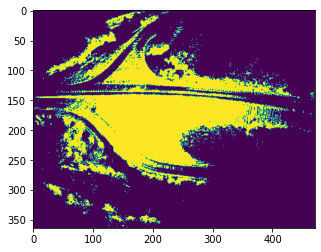

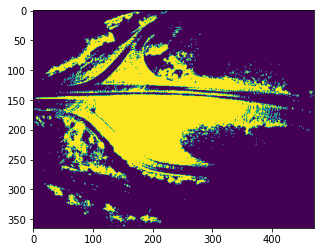

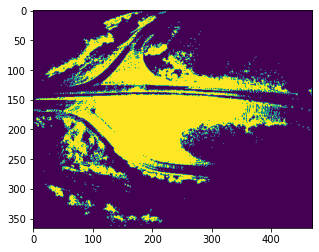

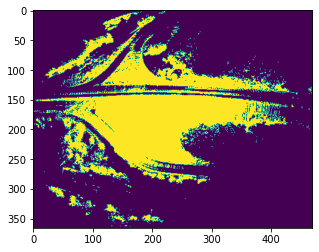

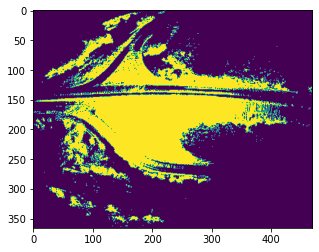

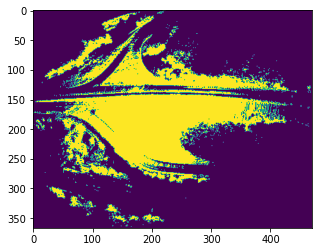

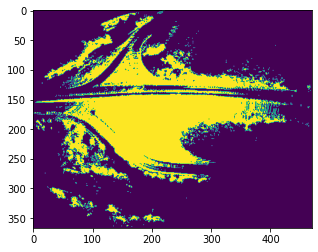

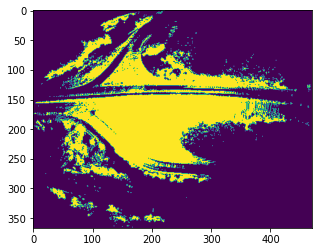

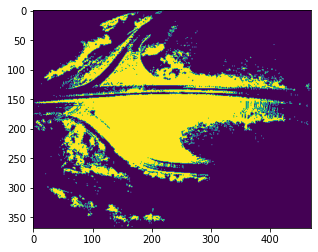

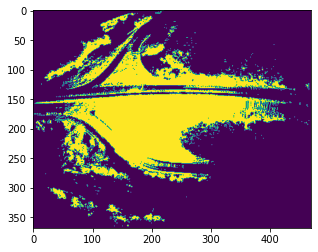

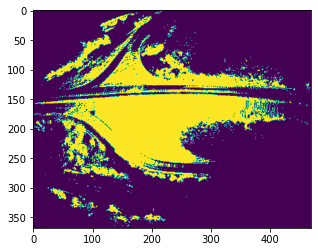

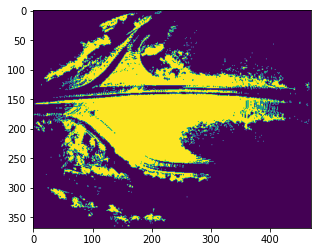

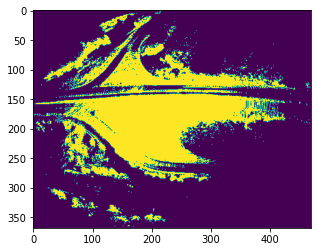

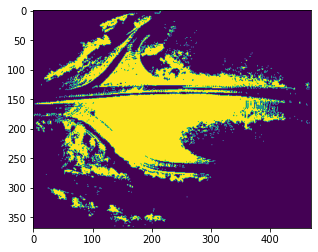

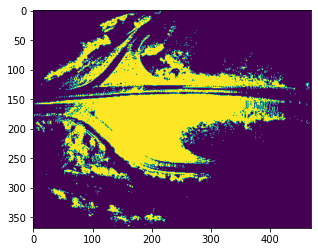

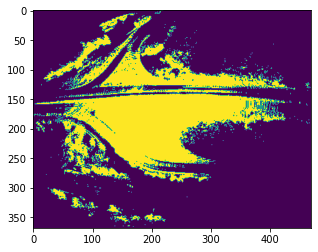

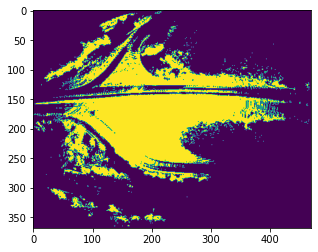

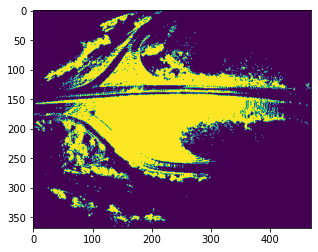

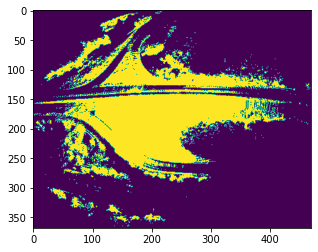

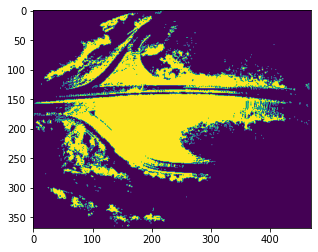

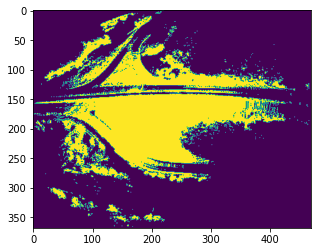

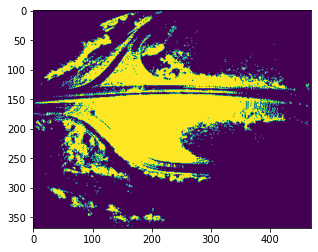

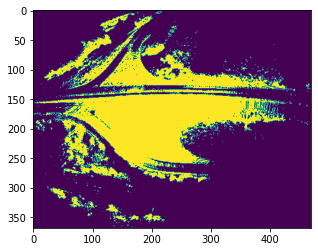

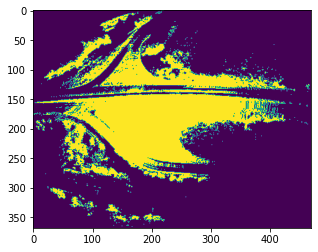

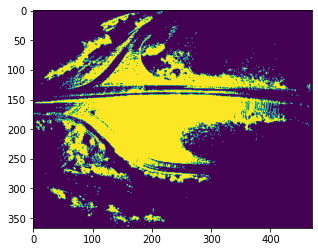

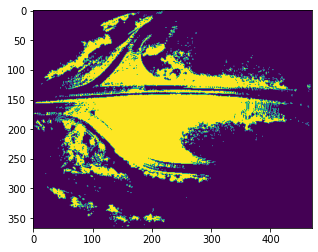

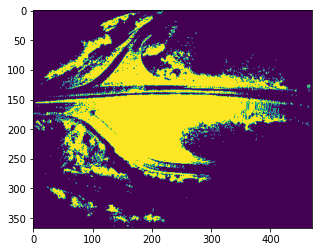

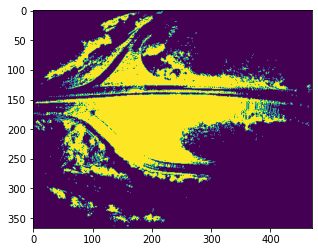

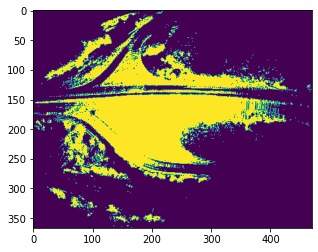

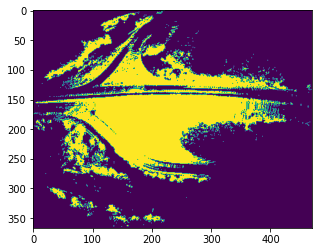

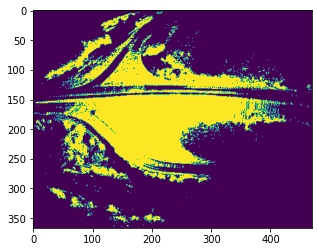

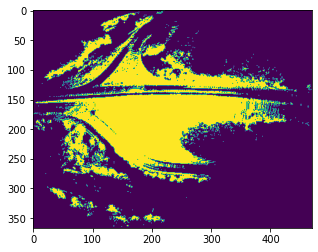

In [36]:
for frame in range(len(camera_frame)):
    plot_grid(occupancy_grid(world_to_camera(frame, world_frame)))

The occupancy grid obtained in the second part is denser, more detailed, covers more area, and shows the path more clearly than the occupancy grid obtained in the first part. This happens because it contains more points in the point cloud (registered point cloud) and covers a larger area (all 77 point clouds are combined).

## Thank you